## Introduction

Tujuan dari notebook ini adalah menjalankan pengelompokan K-Means untuk melihat apakah algoritme berhasil mengelompokkan berita menjadi `true` & `false` hanya dengan menggunakan kata-kata di artikel.

Datasets: https://www.kaggle.com/datasets/clmentbisaillon/fake-and-real-news-dataset

## Imports

In [2]:
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt #  plotting and data visualization
import seaborn as sns # improve visuals
sns.set() # Set as default style

import string # python library
import re # regex library

from gensim.parsing.preprocessing import preprocess_string, strip_tags, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short # Preprocesssing
from gensim.models import Word2Vec # Word2vec

from sklearn import cluster # Kmeans clustering
from sklearn import metrics # Metrics for evaluation
from sklearn.decomposition import PCA #PCA
from sklearn.manifold import TSNE #TSNE

## Data Analysis & Cleanup

In [3]:
fake = pd.read_csv('../input/fake-and-real-news-dataset/Fake.csv')
true = pd.read_csv('../input/fake-and-real-news-dataset/True.csv')

In [4]:
fake.head(10)

,title,text,subject,date
0,Donald Trump Sends Out Embarrassing New Year’...,Donald Trump just couldn t wish all Americans ...,News,"December 31, 2017"
1,Drunk Bragging Trump Staffer Started Russian ...,House Intelligence Committee Chairman Devin Nu...,News,"December 31, 2017"
2,Sheriff David Clarke Becomes An Internet Joke...,"On Friday, it was revealed that former Milwauk...",News,"December 30, 2017"
3,Trump Is So Obsessed He Even Has Obama’s Name...,"On Christmas day, Donald Trump announced that ...",News,"December 29, 2017"
4,Pope Francis Just Called Out Donald Trump Dur...,Pope Francis used his annual Christmas Day mes...,News,"December 25, 2017"
5,Racist Alabama Cops Brutalize Black Boy While...,The number of cases of cops brutalizing and ki...,News,"December 25, 2017"
6,"Fresh Off The Golf Course, Trump Lashes Out A...",Donald Trump spent a good portion of his day a...,News,"December 23, 2017"
7,Trump Said Some INSANELY Racist Stuff Inside ...,In the wake of yet another court decision that...,News,"December 23, 2017"
8,Former CIA Director Slams Trump Over UN Bully...,Many people have raised the alarm regarding th...,News,"December 22, 2017"
9,WATCH: Brand-New Pro-Trump Ad Features So Muc...,Just when you might have thought we d get a br...,News,"December 21, 2017"


In [5]:
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",WASHINGTON (Reuters) - The head of a conservat...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,WASHINGTON (Reuters) - Transgender people will...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,WASHINGTON (Reuters) - The special counsel inv...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,WASHINGTON (Reuters) - Trump campaign adviser ...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,SEATTLE/WASHINGTON (Reuters) - President Donal...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...","WEST PALM BEACH, Fla./WASHINGTON (Reuters) - T...",politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...","WEST PALM BEACH, Fla (Reuters) - President Don...",politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,The following statements were posted to the ve...,politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,WASHINGTON (Reuters) - Alabama Secretary of St...,politicsNews,"December 28, 2017"


Masalah pertama seperti yang terlihat di atas adalah data True berisi:

1. Penafian Reuters bahwa artikel tersebut adalah tweet
> "The following statements were posted to the verified Twitter accounts of U.S. President Donald Trump, @realDonaldTrump and @POTUS.  The opinions expressed are his own. Reuters has not edited the statements or confirmed their accuracy.  @realDonaldTrump"


2. Nama Kota dan penerbit di awal
> WASHINGTON (Reuters)

jadi di blok kode berikutnya saya menghapus ini dari data

In [6]:
# Berikut cara kasar menghilangkan disclaimer tweet @realDonaldTrump dan State/Publisher di awal teks

cleansed_data = []
for data in true.text:
    if "@realDonaldTrump : - " in data:
        cleansed_data.append(data.split("@realDonaldTrump : - ")[1])
    elif "(Reuters) -" in data:
        cleansed_data.append(data.split("(Reuters) - ")[1])
    else:
        cleansed_data.append(data)

true["text"] = cleansed_data
true.head(10)

,title,text,subject,date
0,"As U.S. budget fight looms, Republicans flip t...",The head of a conservative Republican faction ...,politicsNews,"December 31, 2017"
1,U.S. military to accept transgender recruits o...,Transgender people will be allowed for the fir...,politicsNews,"December 29, 2017"
2,Senior U.S. Republican senator: 'Let Mr. Muell...,The special counsel investigation of links bet...,politicsNews,"December 31, 2017"
3,FBI Russia probe helped by Australian diplomat...,Trump campaign adviser George Papadopoulos tol...,politicsNews,"December 30, 2017"
4,Trump wants Postal Service to charge 'much mor...,President Donald Trump called on the U.S. Post...,politicsNews,"December 29, 2017"
5,"White House, Congress prepare for talks on spe...",The White House said on Friday it was set to k...,politicsNews,"December 29, 2017"
6,"Trump says Russia probe will be fair, but time...",President Donald Trump said on Thursday he bel...,politicsNews,"December 29, 2017"
7,Factbox: Trump on Twitter (Dec 29) - Approval ...,While the Fake News loves to talk about my so-...,politicsNews,"December 29, 2017"
8,Trump on Twitter (Dec 28) - Global Warming,"Together, we are MAKING AMERICA GREAT AGAIN! b...",politicsNews,"December 29, 2017"
9,Alabama official to certify Senator-elect Jone...,Alabama Secretary of State John Merrill said h...,politicsNews,"December 28, 2017"


In [7]:
true.text[7]

'While the Fake News loves to talk about my so-called low approval rating, @foxandfriends just showed that my rating on Dec. 28, 2017, was approximately the same as President Obama on Dec. 28, 2009, which was 47%...and this despite massive negative Trump coverage & Russia hoax! [0746 EST] - Why is the United States Post Office, which is losing many billions of dollars a year, while charging Amazon and others so little to deliver their packages, making Amazon richer and the Post Office dumber and poorer? Should be charging MUCH MORE! [0804 EST] -- Source link: (bit.ly/2jBh4LU) (bit.ly/2jpEXYR) '

Beberapa teks masih mengandung berbagai karakter/kata seperti:

1. Links
2. Timestamps
3. Brackets
4. Angka

Jadi kami akan menghapus semua karakter tersebut dari data asli dan palsu menggunakan prapemrosesan genlib dan regex khusus untuk tautan dalam persiapan untuk Word2Vec

Namun sebelumnya, judul dan teks akan digabung menjadi satu agar bisa diproses terlebih dahulu secara bersamaan. Saya juga akan menambahkan label asli dan palsu yang nantinya akan digunakan untuk mengevaluasi pengelompokan kita

In [8]:
# Merging title and text
fake['Sentences'] = fake['title'] + ' ' + fake['text']
true['Sentences'] = true['title'] + ' ' + true['text']

# Adding fake and true label
fake['Label'] = 0
true['Label'] = 1

# We can merge both together since we now have labels
final_data = pd.concat([fake, true])

# Randomize the rows so its all mixed up
final_data = final_data.sample(frac=1).reset_index(drop=True)

# Drop columns not needed
final_data = final_data.drop(['title', 'text', 'subject', 'date'], axis = 1)

final_data.head(10)

,Sentences,Label
0,WATCH: Christian Right Founder Condemns Them ...,0
1,AmeriKKKa: Arrested For Drinking Coffee While...,0
2,Kushner Cos says to skip China marketing push ...,1
3,Cyprus says it plans to help defuse Lebanese c...,1
4,"Reeking Of Desperation, Trump Sends Out ‘Poll...",0
5,California sues Trump administration over bord...,1
6,Freeport Indonesia reopens mine access after s...,1
7,WATCH MICHELLE OBAMA Take One Last Walk Throug...,0
8,Iraq orders truce with Kurds to allow peaceful...,1
9,MEALS ON WHEELS Shuts the Lyin’ Lefties Up Wit...,0


In [9]:
# Here we preprocess the sentences
def remove_URL(s):
    regex = re.compile(r'https?://\S+|www\.\S+|bit\.ly\S+')
    return regex.sub(r'',s)

# Preprocessing functions to remove lowercase, links, whitespace, tags, numbers, punctuation, strip words
CUSTOM_FILTERS = [lambda x: x.lower(), strip_tags, remove_URL, strip_punctuation, strip_multiple_whitespaces, strip_numeric, remove_stopwords, strip_short]

# Here we store the processed sentences and their label
processed_data = []
processed_labels = []

for index, row in final_data.iterrows():
    words_broken_up = preprocess_string(row['Sentences'], CUSTOM_FILTERS)
    # This eliminates any fields that may be blank after preprocessing
    if len(words_broken_up) > 0:
        processed_data.append(words_broken_up)
        processed_labels.append(row['Label'])

## Word2Vec

In [10]:
# Word2Vec model trained on processed data
model = Word2Vec(processed_data, min_count=1)

In [11]:
model.wv.most_similar("country")

[('nation', 0.8196110129356384),
 ('america', 0.6577850580215454),
 ('europe', 0.5864822268486023),
 ('countries', 0.5603359937667847),
 ('europeans', 0.5118465423583984),
 ('world', 0.5094942450523376),
 ('prosperous', 0.503139317035675),
 ('continent', 0.5015949010848999),
 ('region', 0.49547964334487915),
 ('realize', 0.4872097074985504)]

## Sentence Vectors

In [12]:
# Mendapatkan vektor suatu kalimat berdasarkan rata-rata seluruh vektor kata dalam kalimat tersebut
# Kami mendapatkan rata-rata karena ini memperhitungkan panjang kalimat yang berbeda

def ReturnVector(x):
    try:
        return model[x]
    except:
        return np.zeros(100)
    
def Sentence_Vector(sentence):
    word_vectors = list(map(lambda x: ReturnVector(x), sentence))
    return np.average(word_vectors, axis=0).tolist()

X = []
for data_x in processed_data:
    X.append(Sentence_Vector(data_x))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


In [13]:
X_np = np.array(X)
X_np.shape

(44889, 100)

## Clustering

In [14]:
# Training for 2 clusters (Fake and Real)
kmeans = cluster.KMeans(n_clusters=2, verbose=1)

# Fit predict will return labels
clustered = kmeans.fit_predict(X_np)

Initialization complete
Iteration 0, inertia 760261.2989453649
Iteration 1, inertia 454442.8791634002
Iteration 2, inertia 448742.8032355771
Iteration 3, inertia 446608.3426688809
Iteration 4, inertia 445290.36263602733
Iteration 5, inertia 444480.66868834465
Iteration 6, inertia 444060.46480125206
Iteration 7, inertia 443875.79142591514
Iteration 8, inertia 443805.2330245267
Iteration 9, inertia 443780.13955492876
Iteration 10, inertia 443770.31913952326
Iteration 11, inertia 443766.8839656737
Iteration 12, inertia 443765.67805306095
Converged at iteration 12: center shift 1.0881686279588365e-05 within tolerance 1.180929266351019e-05
Initialization complete
Iteration 0, inertia 777800.0965028603
Iteration 1, inertia 483310.0674880967
Iteration 2, inertia 462179.56831336435
Iteration 3, inertia 448743.8719010285
Iteration 4, inertia 444668.0366183116
Iteration 5, inertia 443918.7211715298
Iteration 6, inertia 443791.2234559418
Iteration 7, inertia 443770.02833901305
Iteration 8, inerti

In [15]:
testing_df = {'Sentence': processed_data, 'Labels': processed_labels, 'Prediction': clustered}
testing_df = pd.DataFrame(data=testing_df)

testing_df.head(10)

,Sentence,Labels,Prediction
0,"[watch, christian, right, founder, condemns, s...",0,0
1,"[amerikkka, arrested, drinking, coffee, black,...",0,0
2,"[kushner, cos, says, skip, china, marketing, p...",1,1
3,"[cyprus, says, plans, help, defuse, lebanese, ...",1,1
4,"[reeking, desperation, trump, sends, ‘poll’, a...",0,0
5,"[california, sues, trump, administration, bord...",1,1
6,"[freeport, indonesia, reopens, access, shootin...",1,1
7,"[watch, michelle, obama, walk, house, forced, ...",0,0
8,"[iraq, orders, truce, kurds, allow, peaceful, ...",1,1
9,"[meals, wheels, shuts, lyin’, lefties, truth, ...",0,1


Hasil di atas menunjukkan bahwa mereka mengelompokkannya dengan benar dalam beberapa kasus di mana 0 adalah berita palsu dan 1 adalah berita nyata

In [16]:
correct = 0
incorrect = 0
for index, row in testing_df.iterrows():
    if row['Labels'] == row['Prediction']:
        correct += 1
    else:
        incorrect += 1
        
print("Correctly clustered news: " + str((correct*100)/(correct+incorrect)) + "%")

Correctly clustered news: 87.33542738755597%


## Visualization

In [17]:
# PCA of sentence vectors
pca = PCA(n_components=2)
pca_result = pca.fit_transform(X_np)

PCA_df = pd.DataFrame(pca_result)
PCA_df['cluster'] = clustered
PCA_df.columns = ['x1','x2','cluster']

In [18]:
# T-SNE
tsne = TSNE(n_components=2)
tsne_result = tsne.fit_transform(pca_result)

TSNE_df = pd.DataFrame(tsne_result)
TSNE_df['cluster'] = clustered
TSNE_df.columns = ['x1','x2','cluster']

Text(0.5, 1.0, 'Visualized on PCA')

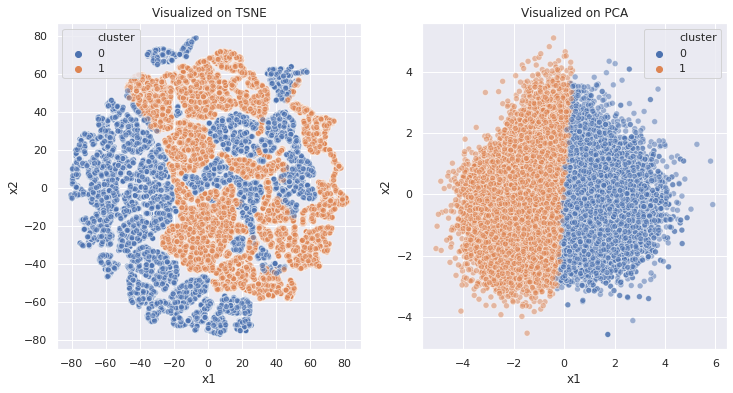

In [20]:
# Plots
fig, ax = plt.subplots(1, 2, figsize=(12,6))
sns.scatterplot(data=PCA_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[1])
sns.scatterplot(data=TSNE_df,x='x1',y='x2',hue='cluster',legend="full",alpha=0.5,ax=ax[0])
ax[0].set_title('Visualized on TSNE')
ax[1].set_title('Visualized on PCA')

## Custom News Tests

In [21]:
# Testing with fake news generated from https://www.thefakenewsgenerator.com/
onion_data = "Flint Residents Learn To Harness Superpowers, But Trump Gets Away Again They developed superpowers after years of drinking from a lead-poisoned water supply. But just having incredible abilities doesn't make them superheroes. Not yet. Donald Trump faced off against the superpowered civilians but he got away before they could catch him"

# Preprocess article
onion_data = preprocess_string(onion_data, CUSTOM_FILTERS)

# Get sentence vector
onion_data = Sentence_Vector(onion_data)

# Get prediction
kmeans.predict(np.array([onion_data]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([0], dtype=int32)

In [22]:
# News from BBC

bbc_data = "Nasa Mars 2020 Mission's MiMi Aung on women in space Next year, Nasa will send a mission to Mars. The woman in charge of making the helicopter that will be sent there – which is set to become the first aircraft to fly on another planet – is MiMi Aung. At 16, MiMi travelled alone from Myanmar to the US for access to education. She is now one of the lead engineers at Nasa. We find out what it's like being a woman in space exploration, and why her mum is her biggest inspiration."

# Preprocess article
bbc_data = preprocess_string(bbc_data, CUSTOM_FILTERS)

# Get sentence vector
bbc_data = Sentence_Vector(bbc_data)

# Get prediction
kmeans.predict(np.array([bbc_data]))

/opt/conda/lib/python3.7/site-packages/ipykernel_launcher.py:6: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  


array([1], dtype=int32)